# 3. Решающие деревья

### 1. Общее описание
Решающее дерево - это алгоритм, который может быть применен, как для задачи классификации, так и регрессии. В листовых вершинах дерева хранится то, что мы хотим предсказать (метка класса или предсказываемое значение). А во всех нелистовых находится некоторое логическое правило на основе признакового описания объекта. Оно определяет к какой ветви дерева относится обрабатываемый объект. Алгоритм предсказания происходит следующим образом. Сначала мы находимся в корне, и применяем правило, хранящееся там. На основе этого правила мы переходим в одну из дочерних вершин. Теперь мы находимся в корне некоторого поддерева и, повторяя такие шаги, будем погружаться дальше, пока не достигнем листовой вершины. А в ней уже хранится значение, которое мы вернем для полученного объекта.

#### Примеры правил
1. Пороговое правило - деление происходит на две ветви. Если значение признака больше порогового, то идем в правого потомка, иначе в левого $(x^i > \theta)$.
2. Категориальный признак принимает значения $c_1, \dots, c_n$. Количество потомков вершины равно $n$ и мы переходим по $i$-й ветви, если значение признака $c_i$.
3. Для категориального признака выбрано какое-то оптимальное бинарное разбиение.

#### Задание
1. Ознакомьтесь с [реализацией](http://scikit-learn.org/stable/modules/tree.html#tree) решающих деревьев билиотеки sklearn. Посмотрите эти два примера: 
  - [Задача регрессии](http://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#sphx-glr-auto-examples-tree-plot-tree-regression-py)
  - [Задача классификации](http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html#sphx-glr-auto-examples-tree-plot-iris-py)
2. Воспроизведите пример классификации ирисов Фишера. Отобразите бинарное дерево в виде графа. 
3. Приведите графики в зависимости от глубины дерева.
4. Предложите функцию вида $z(x, y)$, которая имеет интересный график в пределах $|x|, |y| \leq 1$.
5. Апроксимируйте ее с помощью решающего дерева. Изобразите исходную функцию и полученную модель.

In [202]:
import collections
import itertools
import pydotplus

import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz

from IPython.display import Image

%matplotlib inline

Выберем несколько комбинаций парных признаков. Обучим классификатор на них, а затем покажем, как дерево разбивает плоскость на классы.

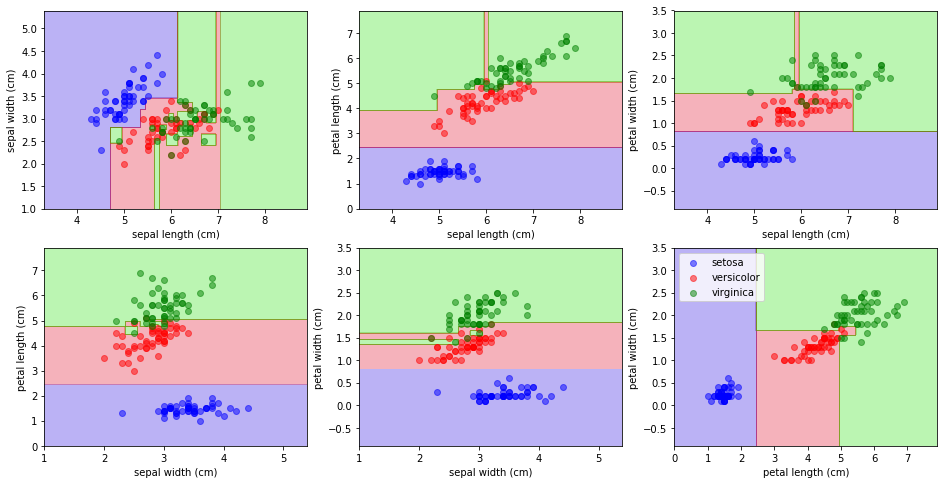

In [9]:
n_classes = 3
colors = 'brg'

iris = load_iris()

plt.figure(figsize=(16, 8))
for n, feature_ids in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    X_train = iris.data[:, feature_ids]
    y_train = iris.target

    clf = DecisionTreeClassifier().fit(X_train, y_train)
    plt.subplot(2, 3, n + 1)

    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.01),
        np.arange(y_min, y_max, 0.01)
    )
        
    X_test = np.vstack([xx.ravel(), yy.ravel()]).T
    y_pred = clf.predict(X_test)
    y_pred = y_pred.reshape(xx.shape)
    
    plt.contourf(xx, yy, y_pred, cmap=colors, alpha=0.3)
    plt.xlabel(iris.feature_names[feature_ids[0]])
    plt.ylabel(iris.feature_names[feature_ids[1]])

    for i, color in zip(range(n_classes), colors):
        idx = np.where(y_train == i)
        plt.scatter(
            X_train[idx, 0], 
            X_train[idx, 1],
            cmap = colors,
            label = iris.target_names[i],
            c = color,
            alpha = 0.5,
        )

plt.legend()
plt.show()

Теперь отобразим схему дерева в виде графа. Для данной визуализации необходимо поставить библиотеки **pydotplus** и **GraphViz**.

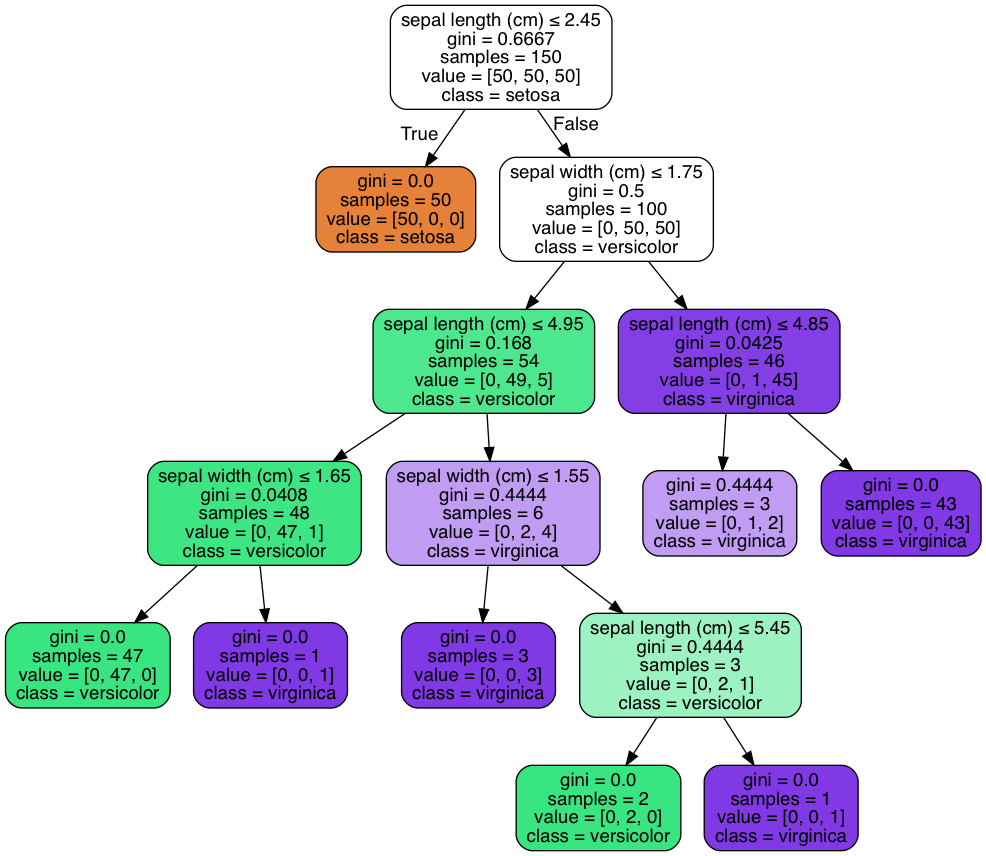

In [14]:
dot_data = export_graphviz(
    clf,
    out_file = None, 
    feature_names = iris.feature_names,  
    class_names = iris.target_names,  
    filled = True,
    rounded = True,  
    special_characters = True
)

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

В качестве $z(x,y)$ возьмем функцию [Растригина](https://en.wikipedia.org/wiki/Rastrigin_function).
$$ f(x) = An + \sum_{i=1}^{n} [x_i^2 - Acos(2\pi x_i)] $$
Где $ A = 10$, а $n$ - размерность.

In [15]:
def rastrigin_function(x, y, A=10):
    return 2*A + np.floor(x**2 - A * np.cos(2*np.pi*x)) + np.floor(y**2 - A * np.cos(2*np.pi*y))

Отобразим сначала саму функцию.

In [16]:
min_x, max_x = -1.12, 1.12
min_y, max_y = -1.12, 1.12

x = np.arange(min_x, max_x, 0.001)
y = np.arange(min_y, max_y, 0.001)

xx, yy = np.meshgrid(x, y)

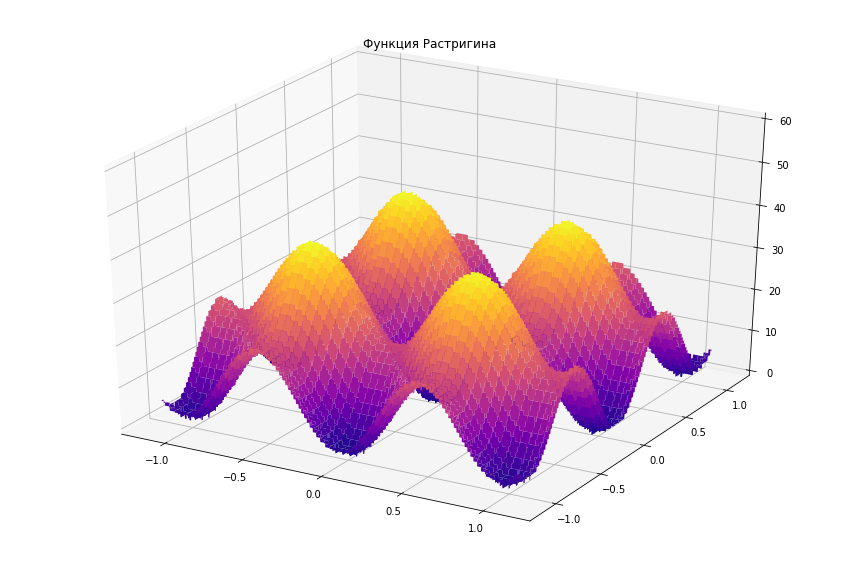

In [18]:
fig = plt.figure(figsize=(15, 10))

ax = plt.subplot('111', projection='3d')
ax.plot_surface(xx, yy, rastrigin_function(xx, yy), cmap='plasma')
ax.set_zlim(0, 60)

plt.title('Функция Растригина')
plt.show()

Теперь сгенерируем обучающую выборку с помощью равномерного распределения.

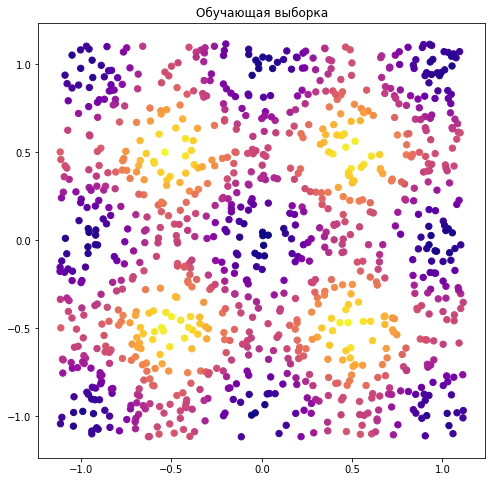

In [19]:
train_n = 1000

X_train = np.random.uniform(min_x, max_x, (train_n, 2))
y_train = rastrigin_function(X_train[:, 0], X_train[:, 1])

plt.figure(figsize=(8, 8))
plt.title('Обучающая выборка')
plt.scatter(X_train[:, 0], X_train[:, 1], s=40, c=y_train, cmap='plasma')
plt.show()

В качестве теста будем использовать сетку, полученную для построения графика.

In [20]:
X_test = np.vstack([xx.flatten(), yy.flatten()]).T

Обучим регрессор и получим предсказание на тестовой выборке.

In [21]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
y_pred = y_pred.reshape(xx.shape)

Теперь отобразим предсказание в виде графика. Видна ступенчатая природа регрессора, что хорошо объяснимо. В каждом листе дерево всегда предсказывает константу. Однако, если значительно увеличить количество обучающих примеров, к примеру, до $10^5$, то качество значительно улучшится и модель станет более гладкой.

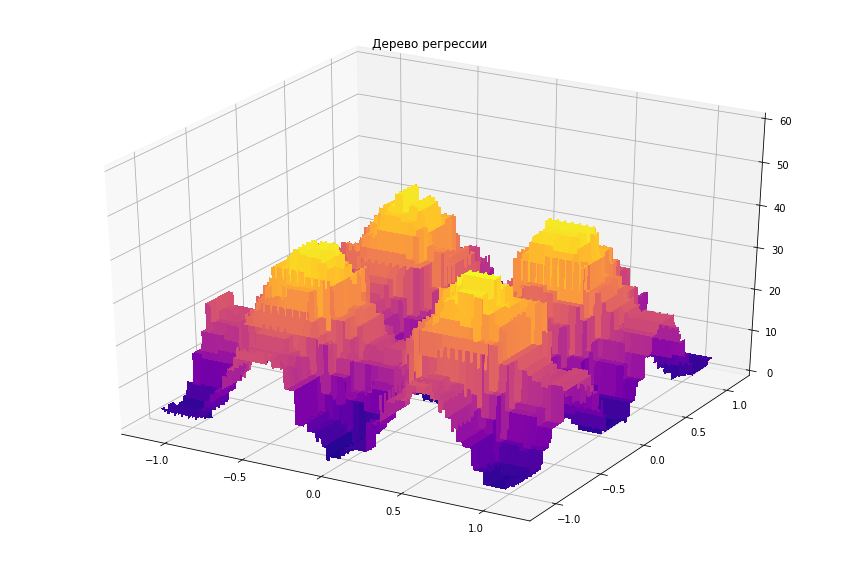

In [22]:
plt.figure(figsize=(15, 10))
ax = plt.gca(projection='3d')

ax.plot_surface(xx, yy, y_pred, cmap='plasma', linewidth=0, antialiased=False)
ax.set_zlim(0, 60)

plt.title('Дерево регрессии')
plt.show()

И для наглядности еще покажем вид сверху. Здесь хорошо видно, как дерево предсказывает константные значения на обученных участках.

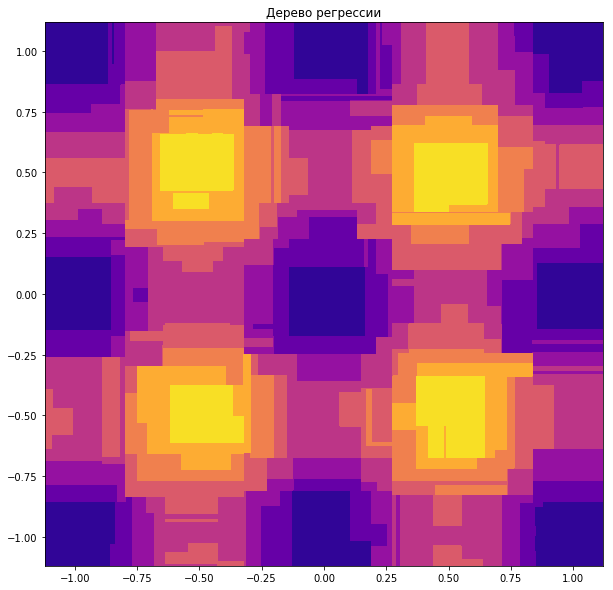

In [24]:
plt.figure(figsize=(10, 10))
plt.contourf(xx, yy, y_pred, cmap='plasma')
plt.title('Дерево регрессии')
plt.show()

### 2. Процесс построения
Существуют различные модификации деревьев, а также способы их построения. Мы подробно разберем CART-деревья, они могут быть использованы для задачи регрессии и классификации. Это бинарные решающие дереьвя (у любой нелистовой вершины только два потомка). В качесте логического правила используется пороговое $(x^i > \theta)$.

Алгоритм построения устроен рекурсивно.
1. Рассматривается текущая вершина, если выполнен критерий остановки, то вершина становится листовой, работа завершена. Таким критерием может быть достигнутая максимальная глубина дерева или минимальное количество элементов в вершине.
2. Выбирается оптимальный критерий для деления (возможные метрики описаны ниже).
3. Проверяется допустимость такого разделения (к примеру, количество объектов в листьях или допустимое значение метрики для листьев).
4. Если разбиение доступно, то алгоритм запускается рекурсивно для двух новых полученных вершин.

Стоит отметить, что алгоритм имеет жадный характер. Это сделано в угоду быстродействию, так как построение оптимального решающего дерева трудоемкая задача.

#### Задание
1. Попробуйте оценить сложность поиска оптимального разбиения. Если количество объектов равно $N$, а количество признаков $F$.
2. Создайте XOR-выборку. Есть всего два признака, при этом $|x_1|, |x_2| <= 1$. Точки распределены равномерно. Класс точки определяется по правилу $sgn(sgn(x_1) \cdot sgn(x_2))$. Обучите модель на выборке, покажите работу модели по аналогии с задачей классификации ирисов. Что происходит с ростом глубины дерева? С уменьшением размера выборки?

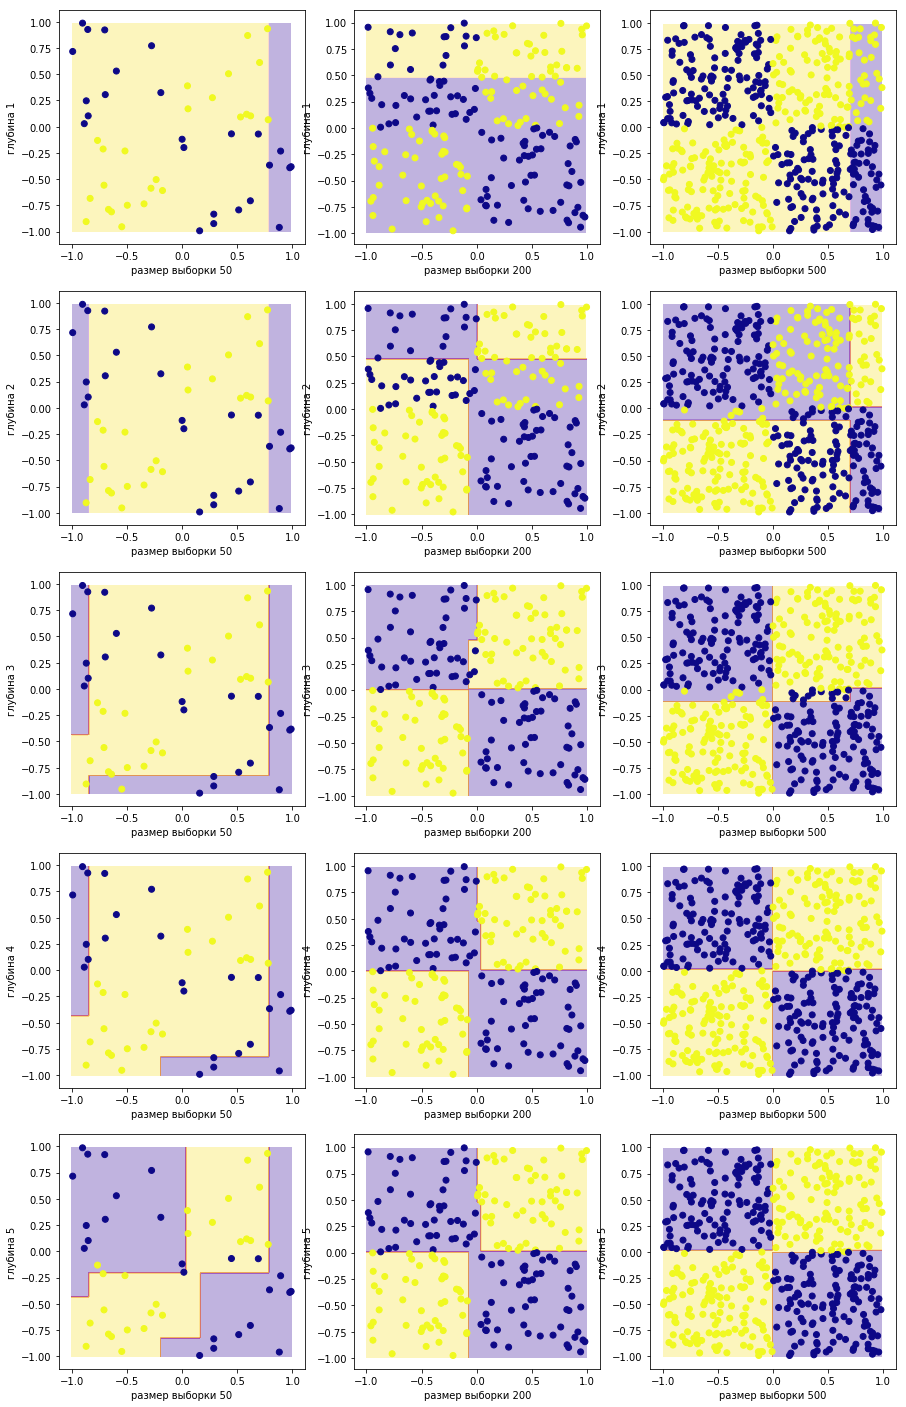

In [26]:
sizes = [50, 200, 500]
depthes = [1, 2, 3, 4, 5]

height, width = len(depthes), len(sizes)

xx, yy = np.meshgrid(
    np.arange(-1, 1, 0.01),
    np.arange(-1, 1, 0.01)
)

X_test = np.vstack([xx.flatten(), yy.flatten()]).T

fig = plt.figure(figsize=(5*width, 5*height))
for i, size in enumerate(sizes):
    X_train = np.random.uniform(-1, 1, (size, 2))
    y_train = np.sign(np.sign(X_train[:, 0]) * np.sign(X_train[:, 1]))
    
    for j, depth in enumerate(depthes):
        ax = fig.add_subplot(height, width, j * width + i + 1)
        
        clf = DecisionTreeClassifier(max_depth=depth)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_pred = y_pred.reshape(xx.shape)
        
        plt.contourf(xx, yy, y_pred, cmap='plasma', alpha=0.3)
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='plasma')
        
        ax.set_ylabel(f'глубина {depth}')
        ax.set_xlabel(f'размер выборки {size}')

#### Мера неопределенности
Хочется ввести такую меру, которая показывала бы, на сколько просто сделать предсказание в рамках текущего узла дерева, зная о том, какие объекты в него попали. Пусть в узле всего $N$ объектов и для них известны $y$-ки.

Для задачи регрессии все достаточно просто, в качестве неопределенности можно использовать обычную вариацию
$$H = \frac{1}{N} \sum_{i=1}^{N} \big(y_i - \overline{y} \big)^2,$$ 
где $\overline{y} = \frac{1}{N} \sum_{i=1}^{N} y_i$ - средне значение $y$ в узле.

Для задачи классификации ситуация немного сложнее. Сначала необхоидимо понять, какими свойствами должна обладать эта мера. Пусть $p_y$ - вероятность выбрать объект класса $y$ в рассматриваемом узле
$$p_y = \frac{1}{N} \sum_{i=1}^{N} [y_i = y]$$.
1. Eсли для какого-то класса $y$ вероятность равна $1$, а для остальных $0$, то это неопределенность равна нулю.
2. Если все $p_y$ равны между собой, то неопределенность максимальна.
3. Симметричность. Можно поменять значения $p_y$ и $p_{y'}$ местами, значение неопределенности не изменится.

Первый вариант меры, который сразу приходит в голову, это уровень энтропии в узле (entropy)
$$H = \sum_{y} - p_y \log p_y.$$
Чем больше неопределенности (информации) хранится в узле, тем сложнее сделать классификацию.

Другая распространенная мера - коэффициент Джини (Gini coefficient)
$$H = \sum_{y} p_y (1 - p_y).$$
Его можно интерпретировать, как вероятность сделать ошибку классификации, если объект выбирается  случайно. Вероятность выбрать класс $y$ равна $p_y$, а вероятность ошибки равна $1 - p_y$ (предполагается, что правильная метка будет назначена также с вероятностью $p_y$).

Обладая данными метриками можно легко ввести оценку качества разбиения. Посчитаем уровень неопределенности для левого и правого узла $H_{L}$ и $H_{R}$ соответственно. Тогда будем считать оптимальны то разбиение, которое максимизирует следующую величину
$$Gain = H - \big( \frac{N_L}{N} H_{L} + \frac{N_R}{N} H_{R} \big).$$ В частности, если $H$ - это энтропия, то величину $Gain$ можно понимать, как количество полученной информации, если известно больше ли признак указанного порога.

#### Задание
1. Для бинарной классификации $y \in \{ -1, +1\}$ значение коэффициента Джини и энтропию можно выразить через одну вероятность $p_{-1} = 1 - p_{+1}$. Постройте график в осях $p_{+1} \times H$ для обоих метрик.
2. Изучите датасет ["Титаник"](https://www.kaggle.com/c/titanic), это известная задача бинарной классификации.
3. Реализуйте обе метрики (энтропия и Джини), попробуйте поприменять ее к различным признакам датасета.
4. Для каждого признака найдите идеальное разбиение относительно обоих метрик.

Пусть $q = 1 - p$, тогда для Джини получаем
$$ G(p) =  2pq$$
Аналогично для энтропии получаем:
$$ E(p) =  -p\log(p) - q\log(q)$$

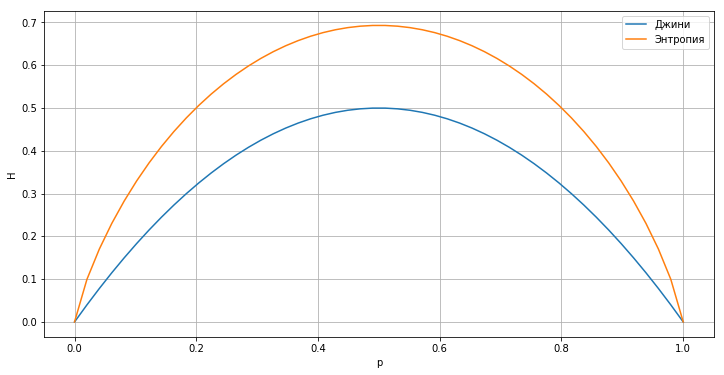

In [28]:
def binary_gini(p):
    return 2*p*(1-p)

def binary_entropy(p):
    return sc.stats.entropy([p, 1-p])

fig = plt.figure(figsize=(12, 6))

x = np.linspace(0.0, 1.0, 50)
plt.plot(x, binary_gini(x), label='Джини')
plt.plot(x, binary_entropy(x), label='Энтропия')

plt.xlabel('p')
plt.ylabel('H')

plt.grid()
plt.legend()

plt.show()

Начнем работать с датасетом!
Загрузим данные и посмотрим на них. Для этого будем использовать библиотеку **Pandas**.

In [129]:
data = pd.read_csv('titanic.train.csv')
N, M = data.shape

In [130]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Определим вспомогательные функции.

In [38]:
def prob(labels):
    counter = collections.Counter(labels)
    total = sum(counter.values())
    return np.array([count / total for label, count in counter.items()])

def gini(labels):
    p = prob(labels)
    return (p * (1 - p)).sum()
    
def entropy(labels):
    return sc.stats.entropy(prob(labels))

Определим функцию разбиения для упорядоченного признака. Разбиение будем находить простым перебором всех возможных позиций, предварительно упорядочив объекты по значение текущего признака

In [81]:
def split_ordered_feature(metric, labels, values):
    idx = np.argsort(values)
    
    values = values[idx]
    labels = labels[idx]

    best_split, best_score = None, 0
    
    for i in range(1, len(values)):
        previous = values[i-1]
        current = values[i]

        if previous == current:
            continue 

        left_ratio = i / len(labels)
        right_ratio = 1 - left_ratio
        score = left_ratio * metric(labels[:i]) + right_ratio * metric(labels[i:])
            
        if not best_split or best_score >= score:
            best_split = (current + previous) / 2
            best_score = score
            
    return best_split, best_score

In [82]:
labels = np.array(data['Survived'])

Для начала найдем разбиение для возраста пассажиров.

Разбиение 0.47004425554074386


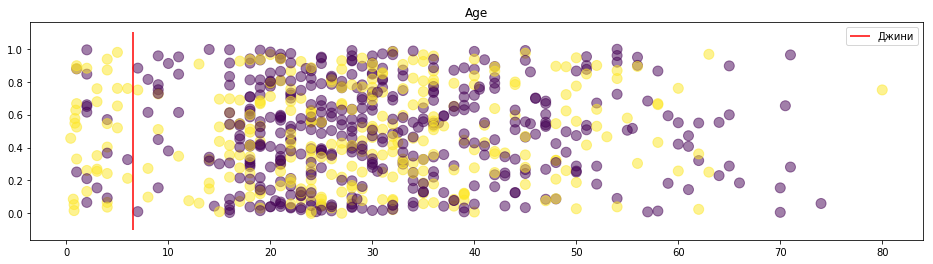

In [123]:
age = np.array(data['Age'])
idx = np.logical_not(np.isnan(age))
age = age[idx]

plt.figure(figsize=(16, 4))
plt.title('Age')
plt.scatter(age, np.random.random(len(age)), c=labels[idx], s=100, alpha=0.5)

split, score = split_ordered_feature(gini, labels[idx], age)
print(f'Разбиение {score}')
plt.vlines(split, -0.1, 1.1, color='red', label='Джини')
plt.legend()

plt.show()

Теперь сделаем то же самое для платы.

Разбиение 0.6185579004972205


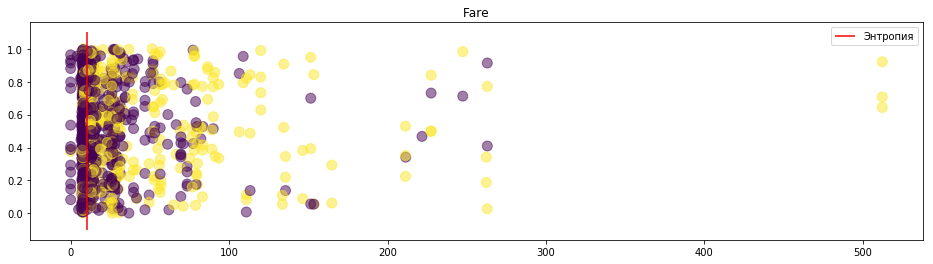

In [122]:
fare = np.array(data['Fare'])
idx = np.logical_not(np.isnan(fare))
fare = fare[idx]

plt.figure(figsize=(16, 4))
plt.title('Fare')
plt.scatter(fare, np.random.random(len(fare)), c=labels[idx], s=100, alpha=0.5)

split, score = split_ordered_feature(entropy, labels[idx], fare)
print(f'Разбиение {score}')
plt.vlines(split, -0.1, 1.1, color='red', label='Энтропия')
plt.legend()

plt.show()

Разбиение не самое удачное. Теперь перейдем к дискретному признаку класса каюты. В принципе можно считать, что классы имеют порядок, поэтому снова применим наше разбиение.

Разбиение 0.4238751054331502


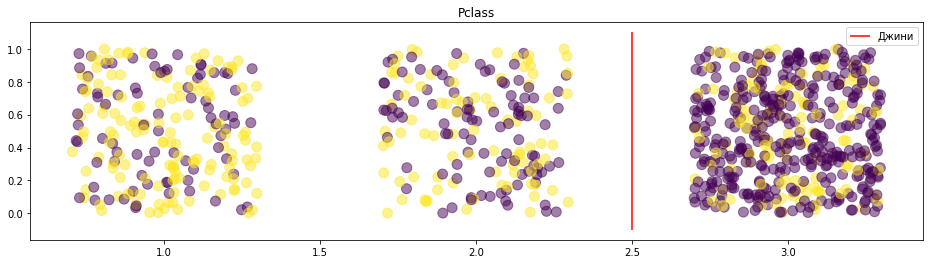

In [121]:
pclass = np.array(data['Pclass'])

plt.figure(figsize=(16, 4))
plt.title('Pclass')

x_shift = np.random.uniform(-0.3, 0.3, len(pclass))
y = np.random.random(len(pclass))
plt.scatter(pclass + x_shift, y, c=labels, s=100, alpha=0.5)

split, score = split_ordered_feature(gini, labels, pclass)
print(f'Разбиение {score}')
plt.vlines(split, -0.1, 1.1, color='red', label='Джини')
plt.legend()

plt.show()

Рассмотрим теперь загадочный признак 'Embarked'. Его значения не совсем понятно, плюс там нет явного порядка, поэтому применим другой способ разбиения.

In [125]:
embarked = np.array(data['Embarked'], dtype=str)
idx = np.array([embarked[i] in 'QSC' for i in range(len(embarked))])
embarked = embarked[idx]

Теперь разбиение будет найдено перебором всевозможных разбиений множества принимаемых значений.

In [126]:
def split_feature(metric, labels, values):
    value_set = np.unique(values)
    
    best_split, best_score = None, 0
    for i in range(1, 1 + len(value_set) // 2):
        for left_set in map(lambda s: np.array(s, dtype=str), itertools.combinations(value_set, i)):
            left_idx = np.array([values[i] in left_set for i in range(len(values))])
            right_idx = np.logical_not(left_idx)
            
            left_ratio = left_idx.astype(int).sum() / len(left_idx)
            right_ratio = 1 - left_ratio
            score = left_ratio * metric(labels[left_idx]) + right_ratio * metric(labels[right_idx])
            
            if not best_split or best_score >= score:
                right_set = np.setdiff1d(value_set, left_set)

                best_split = left_set, right_set
                best_score = score
                
    return best_split, best_score

Схематично обозначим разбиение.

Разбиение 0.4587191424234245


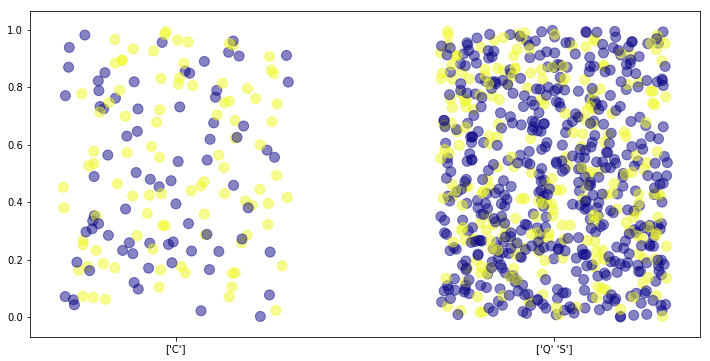

In [127]:
(left_set, right_set), score = split_feature(gini, labels[idx], embarked)
print(f'Разбиение {score}')

left_idx = np.array([embarked[i] in left_set for i in range(len(embarked))])
right_idx = np.logical_not(left_idx)

labels_left = labels[idx][left_idx]
labels_right = labels[idx][right_idx]

x_left = np.random.uniform(-0.3, 0.3, len(labels_left))
y_left = np.random.uniform(0, 1, len(labels_left))

x_right = np.random.uniform(0.7, 1.3, len(labels_right))
y_right = np.random.uniform(0, 1, len(labels_right))

plt.figure(figsize=(12, 6))
plt.xticks([0, 1], (left_set, right_set))

plt.scatter(x_left, y_left, s=100, c=labels_left, cmap='plasma', alpha=0.5)
plt.scatter(x_right, y_right, s=100, c=labels_right, cmap='plasma', alpha=0.5)

plt.show()

#### Обработка пропущенных значений
**Стадия обучения**
Если у объекта нет признака, то мы просто убираем его из дальнешего построения дервева. При этом для вершины $v$:
- Если она нелистовая, то вычисляем вероятность попасть из нее в $k$-ю ветвь $q_{v, k}$.
- Если листовая, то распределение классов $p_{y, v}$.

**Стадия предсказания**
- Если признак определен для объекта, то считаем, что вероятность класса $y$ в вершине $v$ равна вероятности, записанной в дочерней вершине, в которую мы должны перейти ($v$ - текущая вершина, а $c$ - дочерняя)
$$P(y|x,v) = P(y|x,c).$$
- В ином случаем мы считаем, что 
$$P(y|x,v) = \sum_{k} q_{k, v} P(y|x,c_k),$$
а окончательное решение о классе объекта принимается в виде
$$a(x) = P(y|x, r),$$
где $r$ - корневая вершина всего дерева.

#### Механизм отсечения (pruning)
Усечение - это процесс упрощения обученного дерева. Для усечения дерева необходима отдельная контрольная выборка. Существуют различные подходы, рассмотрим один из них.

Усечение проводится снизу вверх, обрабатываются все нелистовые вершины, ошибка считается на контрольной выборке.
1. Если до вершины не дошел ни один элемент контрольной выборки, то узел превращается в лист, в него помещается значение на основе элементов обучающей выборки. 
2. В ином случае рассматриваются следующие варианты:
  - Вычисляется ошибка классификации в текущей конфигурации дерева.
  - Вычисляется ошибка, если выбросить рассматриваемую вершину и вместо нее поставить дочернюю (перебираются все варианты).
  - Ошибка, если вершину сделать листовой и возвращать метку $y$ (перебираются все варианты)
3. Выбирается оптимальный вариант.

#### Достоинства
- Модель можно интерпретировать (при небольшой глубине дерева).
- Модель может работать с пропусками в данных.
- Сама отбирает признаки.

#### Недостатки
- Структура дерева может быть нестабильна в зависимости от обучающей выборки.
- В случае глубоких деревьев легко получить переобученную модель.
- Плохо работает с категориальными признаками, на которых нет порядка.

#### Дополнительное чтение
1. Общее описание [процесса обучения](https://en.wikipedia.org/wiki/Decision_tree_learning);
2. Дерево регрессии и классификации [CART](https://en.wikipedia.org/wiki/Predictive_analytics#Classification_and_regression_trees_.28CART.29);
3. Алгоритм [C4.5](https://en.wikipedia.org/wiki/C4.5_algorithm).

#### Задание
1. Разбейте датасет "Титаник" на обучающую и тестовую выборки.
2. Обучите модель.
3. Подумайте, как нужно преобработать признаки.
4. Добейтесь максимального качества на тестовой выборке.

###  Загрузка данных

Для улучшения качества классификации, устраним пропуски и прошкалируем данные с использованием тестового набора.

In [164]:
train = pd.read_csv('titanic.train.csv')    
test = pd.read_csv('titanic.test.csv')
targets = train.Survived
train.drop('Survived', 1, inplace=True)

combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop('index',inplace=True,axis=1)

In [165]:
combined.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Извлечение имен пассажиров

Рассматривая имена пассажиров, можно было бы задаться вопросом, как их обработать, чтобы извлечь легко интерпретируемую информацию.

Посмотрим более внимательно на примеры:

- Braund, <b> Mr.</b> Owen Harris	
- Heikkinen, <b>Miss.</b> Laina
- Oliva y Ocana, <b>Dona.</b> Fermina
- Peter, <b>Master.</b> Michael J

Можно заметить, что у каждого имени есть приставка! Это может быть простая мисс или миссис, но иногда это может быть что-то более сложное, как Мастер, Сэр или Дона. В этом случае мы могли бы ввести дополнительную информацию о социальном статусе, просто проанализировав имя и извлекая заголовок.

In [166]:
combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())

titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}

combined['Title'] = combined.Title.map(titles)

Эта функция анализирует имена и извлекает заголовки. Затем он отображает заголовки в соответствующей категории.
Мы выбрали:

- Officer
- Royalty 
- Mr
- Mrs
- Miss
- Master

In [167]:
combined.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


### Обработка возраста

Изучая данные, можно увидеть, что в переменной Age отсутствует 177 значений. Это большое количество (~ 13% от набора данных). Просто заменить их средним или средним возрастом может быть не лучшим решением, так как возраст может отличаться по группам и категориям пассажиров.

Чтобы понять, почему, давайте сгруппируем наш набор данных по полу, типу и классу пассажиров.

In [168]:
grouped = combined.groupby(['Sex','Pclass','Title'])
grouped.median()

PassengerId   Age  SibSp  Parch      Fare
Sex    Pclass Title                                             
female 1      Miss           529.5  30.0    0.0    0.0   99.9625
              Mrs            853.5  45.0    1.0    0.0   78.1125
              Officer        797.0  49.0    0.0    0.0   25.9292
              Royalty        760.0  39.0    0.0    0.0   86.5000
       2      Miss           606.5  20.0    0.0    0.0   20.2500
              Mrs            533.0  30.0    1.0    0.0   26.0000
       3      Miss           603.5  18.0    0.0    0.0    8.0500
              Mrs            668.5  31.0    1.0    1.0   15.5000
male   1      Master         803.0   6.0    1.0    2.0  134.5000
              Mr             634.0  41.5    0.0    0.0   47.1000
              Officer        678.0  52.0    0.0    0.0   37.5500
              Royalty        600.0  40.0    0.0    0.0   27.7208
       2      Master         550.0   2.0    1.0    1.0   26.0000
              Mr             723.5  30.0    0.0    0.0   13.0000
              Officer        513.0  41.5    0.0    0.0   13.0000
       3      Master         789.0   6.0    3.0    1.0   22.3583
              Mr             640.5  26.0    0.0    0.0    7.8958

Посмотрите на столбец среднего возраста, как это значение может отличаться в зависимости от Sex, Pclass и Title?

Например:

- Если пассажир женского пола, из класса Pclass 1 - средний возраст 39 лет.
- Если пассажир мужского пола, из класса Pclass 3, с титулом мистера - средний возраст 26 лет.

Давайте создадим функцию, которая заполняет отсутствующий возраст.

In [169]:
def fillAges(row):
    if row['Sex']=='female' and row['Pclass'] == 1:
        if row['Title'] == 'Miss':
            return 30
        elif row['Title'] == 'Mrs':
            return 45
        elif row['Title'] == 'Officer':
            return 49
        elif row['Title'] == 'Royalty':
            return 39

    elif row['Sex']=='female' and row['Pclass'] == 2:
        if row['Title'] == 'Miss':
            return 20
        elif row['Title'] == 'Mrs':
            return 30

    elif row['Sex']=='female' and row['Pclass'] == 3:
        if row['Title'] == 'Miss':
            return 18
        elif row['Title'] == 'Mrs':
            return 31

    elif row['Sex']=='male' and row['Pclass'] == 1:
        if row['Title'] == 'Master':
            return 6
        elif row['Title'] == 'Mr':
            return 41.5
        elif row['Title'] == 'Officer':
            return 52
        elif row['Title'] == 'Royalty':
            return 40

    elif row['Sex']=='male' and row['Pclass'] == 2:
        if row['Title'] == 'Master':
            return 2
        elif row['Title'] == 'Mr':
            return 30
        elif row['Title'] == 'Officer':
            return 41.5

    elif row['Sex']=='male' and row['Pclass'] == 3:
        if row['Title'] == 'Master':
            return 6
        elif row['Title'] == 'Mr':
            return 26

combined.Age = combined.apply(lambda r : fillAges(r) if np.isnan(r['Age']) else r['Age'], axis=1)

In [170]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Title          1309 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 122.8+ KB


Отлично. Недостающие возрасты были восстановлены.

Тем не менее, мы замечаем отсутствие значения в Fare, два отсутствующих значения в Embarked и много недостающих значений в Cabin. Мы вернемся к этим переменным позже.

Давайте теперь обработаем имена.

In [171]:
combined.drop('Name',axis=1,inplace=True)

titles_dummies = pd.get_dummies(combined['Title'],prefix='Title')
combined = pd.concat([combined,titles_dummies],axis=1)

combined.drop('Title',axis=1,inplace=True)

In [172]:
combined.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,1,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0,0
1,2,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0,0
2,3,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0,0
3,4,1,female,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,0,0
4,5,3,male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,0,0


В итоге :
- больше нет имен.
- появились новые двоичные переменные (Title_X).
     - Например, если Title_Mr = 1, то соответствующий заголовок - Mr.

### Обработка остальной части данных

In [173]:
combined.Fare.fillna(combined.Fare.mean(),inplace=True)

In [174]:
combined.Embarked.fillna('S',inplace=True)
embarked_dummies = pd.get_dummies(combined['Embarked'],prefix='Embarked')
combined = pd.concat([combined,embarked_dummies],axis=1)
combined.drop('Embarked',axis=1,inplace=True)

In [175]:
combined.Cabin.fillna('U',inplace=True)
combined['Cabin'] = combined['Cabin'].map(lambda c : c[0]) 
cabin_dummies = pd.get_dummies(combined['Cabin'],prefix='Cabin')
combined = pd.concat([combined,cabin_dummies],axis=1)
combined.drop('Cabin',axis=1,inplace=True)

In [176]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 26 columns):
PassengerId      1309 non-null int64
Pclass           1309 non-null int64
Sex              1309 non-null object
Age              1309 non-null float64
SibSp            1309 non-null int64
Parch            1309 non-null int64
Ticket           1309 non-null object
Fare             1309 non-null float64
Title_Master     1309 non-null uint8
Title_Miss       1309 non-null uint8
Title_Mr         1309 non-null uint8
Title_Mrs        1309 non-null uint8
Title_Officer    1309 non-null uint8
Title_Royalty    1309 non-null uint8
Embarked_C       1309 non-null uint8
Embarked_Q       1309 non-null uint8
Embarked_S       1309 non-null uint8
Cabin_A          1309 non-null uint8
Cabin_B          1309 non-null uint8
Cabin_C          1309 non-null uint8
Cabin_D          1309 non-null uint8
Cabin_E          1309 non-null uint8
Cabin_F          1309 non-null uint8
Cabin_G          1309 non-null uint8

Отлично, больше нет пропущенных значений.

In [177]:
combined.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,1,3,male,22.0,1,0,A/5 21171,7.2500,0,0,...,1,0,0,0,0,0,0,0,0,1
1,2,1,female,38.0,1,0,PC 17599,71.2833,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,3,female,26.0,0,0,STON/O2. 3101282,7.9250,0,1,...,1,0,0,0,0,0,0,0,0,1
3,4,1,female,35.0,1,0,113803,53.1000,0,0,...,1,0,0,1,0,0,0,0,0,0
4,5,3,male,35.0,0,0,373450,8.0500,0,0,...,1,0,0,0,0,0,0,0,0,1


In [178]:
combined['Sex'] = combined['Sex'].map({'male':1,'female':0})

In [179]:
pclass_dummies = pd.get_dummies(combined['Pclass'],prefix="Pclass")
combined = pd.concat([combined,pclass_dummies],axis=1)    
combined.drop('Pclass',axis=1,inplace=True)

In [180]:
def cleanTicket(ticket):
    ticket = ticket.replace('.','')
    ticket = ticket.replace('/','')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip() , ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'


combined['Ticket'] = combined['Ticket'].map(cleanTicket)
tickets_dummies = pd.get_dummies(combined['Ticket'],prefix='Ticket')
combined = pd.concat([combined, tickets_dummies],axis=1)
combined.drop('Ticket',inplace=True,axis=1)

* Эта функция выполняет предварительную обработку билетов путем извлечения префикса билета. Если извлечение префикса невозможно, возвращается XXX.
* Затем она кодирует префиксы с использованием фиктивной кодировки.

### Обработка семей

Создадим новые переменные на основе размера семьи.

In [181]:
combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
combined['Singleton'] = combined['FamilySize'].map(lambda s : 1 if s == 1 else 0)
combined['SmallFamily'] = combined['FamilySize'].map(lambda s : 1 if 2<=s<=4 else 0)
combined['LargeFamily'] = combined['FamilySize'].map(lambda s : 1 if 5<=s else 0)

Эта функция создает 4 новые переменные:

- FamilySize: общее количество родственников, включая пассажира (его / ее).
- Sigleton: булевская переменная, описывающая семейства размером = 1
- SmallFamily: логическая переменная, описывающая семейства из 2 <= size <= 4
- LargeFamily: логическая переменная, описывающая семейства из 5 < size

In [182]:
combined.head()

,PassengerId,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,FamilySize,Singleton,SmallFamily,LargeFamily
0,1,1,22.0,1,0,7.2500,0,0,1,0,...,0,0,0,0,0,0,2,0,1,0
1,2,0,38.0,1,0,71.2833,0,0,0,1,...,0,0,0,0,0,0,2,0,1,0
2,3,0,26.0,0,0,7.9250,0,1,0,0,...,1,0,0,0,0,0,1,1,0,0
3,4,0,35.0,1,0,53.1000,0,0,0,1,...,0,0,0,0,0,1,2,0,1,0
4,5,1,35.0,0,0,8.0500,0,0,1,0,...,0,0,0,0,0,1,1,1,0,0


Как вы можете видеть, они имеют разные области значения. Давайте нормализуем их все, кроме PassengerId, в единичном интервале.

In [184]:
features = list(combined.columns)
features.remove('PassengerId')
combined[features] = combined[features].apply(lambda x: x/x.max(), axis=0)

Возвращаясь к нашей проблеме, теперь мы должны:

1. Разбить объединенный набор данных в набор для обучения и тестирования.
2. Построить предсказания.
3. Оцените модель.

Чтобы оценить нашу модель, мы будем использовать 5-fold cross validation с метрикой Accuracy.

In [185]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5,scoring=scoring)
    return np.mean(xval)

In [208]:
targets = pd.read_csv('titanic.train.csv').Survived

train = combined.ix[0:890]
test = combined.ix[891:]

## Выбор признаков

На данный момент у нас есть 68 признаков. Это довольно большое число.
Предлагается выбрать из них лучшие.

Отбор признаков имеет много преимуществ:

- Это уменьшает избыточность среди данных
- Это ускоряет процесс обучения
- Это уменьшает overfitting

In [209]:
classifier = ExtraTreesClassifier(n_estimators=200)
classifier = clf.fit(train, targets)

In [210]:
features = pd.DataFrame()

features['feature'] = train.columns
features['importance'] = clf.feature_importances_

In [211]:
features.sort_values(['importance'],ascending=False)[:10]

,feature,importance
8,Title_Mr,0.541909
64,FamilySize,0.140798
5,Fare,0.115458
10,Title_Officer,0.047081
0,PassengerId,0.042821
26,Pclass_3,0.037470
2,Age,0.021493
25,Pclass_2,0.021451
60,Ticket_SWPP,0.013883
57,Ticket_STONO,0.010900


Как вы можете заметить, наиболее важными являются Title_Mr, Age, Fare и Sex.
Существует также важная зависимость с Passenger_Id.

Давайте теперь преобразуем наши данные.

In [213]:
model = SelectFromModel(classifier, prefit=True)

train_new = model.transform(train)
test_new = model.transform(test)

### Настройка гиперпараметров

Для нахождения наилучших параметров, будем использовать **GridSearch**.

Преимущество прохода по сетке в том, что его легко имплементировать самому и легко распараллелить. Однако у него есть и серьезные недостатки:

- Он перебирает много заведомо неудачных точек. Допустим, уже имеется набор каких-то конфигураций с результатами или какая-то другая информация. Человек может понять, какие конфигурации точно дадут неприемлимый результат, и догадается не проверять лишний раз эти регионы. Grid search так делать не умеет. 

- Если гиперпараметров много, то размер «ячейки» приходится делать слишком крупным, и можно упустить хороший оптимум. Таким образом, если включить в пространство поиска много лишних гиперпараметров, никак не влияющих на результат, то grid search будет работать намного хуже при том же числе итераций.

In [218]:
ensemble = DecisionTreeClassifier(max_features='sqrt')

parameter_grid = {
    'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'criterion': ['gini','entropy']
}

grid_search = GridSearchCV(
    ensemble,
    param_grid = parameter_grid,
    cv = StratifiedKFold(n_splits=5).split(train, targets)
)

grid_search.fit(train_new, targets)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8092031425364759
Best parameters: {'criterion': 'entropy', 'max_depth': 5}


### 3. Случайный лес (random forest)

Качество предсказывающего алгоритма может значительно улучшиться, если одновременно использовать сразу несколько деревьев.

Обучим независимо $T$ деревье $b_t$, для этого надо соблюдать следующие правила:
  - Каждое дерево обучается на случайной подвыборке;
  - В каждой вершине множество признаков для рассмотрения выбирается случайно (обычно берут $\sqrt{n}$, $\log n$ или  $\frac{1}{k}n$ признаков);
  - Усечений нет.
  
Тогда итоговый алгоритм определяется следующим правилом голосования
$$a(x) = \frac{1}{T} \sum_{t=1}^{T} b_t(x).$$

А для задачи классификации
$$a(x) = \arg \max_{y \in Y} \sum_{t=1}^{T} \big[ b_t(x) = y \big].$$

#### Задание
1. Изучите *ExtraTreeClassifier* и *ExtraTreeRegressor*.
2. Примените рещающий лес для уже предложенной функции $z(x, y)$.
3. Снова постройте график $z(x, y)$ и апроксимации для разного количества деревьев.
4. Отобразите график качества (RMSE) в зависимости от количества дервьев.
5. Примените случайный лес для задачи классификации пассажиров Титаника. Улучшилось ли качество?

Аналогичным способом сгенерируем случайную обучающую выборку, а в качестве теста будем использовать "мелкую сетку".

In [392]:
min_x, max_x = -1.12, 1.12
min_y, max_y = -1.12, 1.12

x = np.arange(min_x, max_x, 0.01)
y = np.arange(min_y, max_y, 0.01)

xx, yy = np.meshgrid(x, y)

In [405]:
train_n = 1000

X_train = np.random.uniform(min_x, max_x, (train_n, 2))
y_train = rastrigin_function(X_train[:, 0], X_train[:, 1])

X_test = np.vstack([xx.flatten(), yy.flatten()]).T
y_test = rastrigin_function(xx, yy)

Посмотрим, как будет меняться качество с увеличением количества деревьев. 

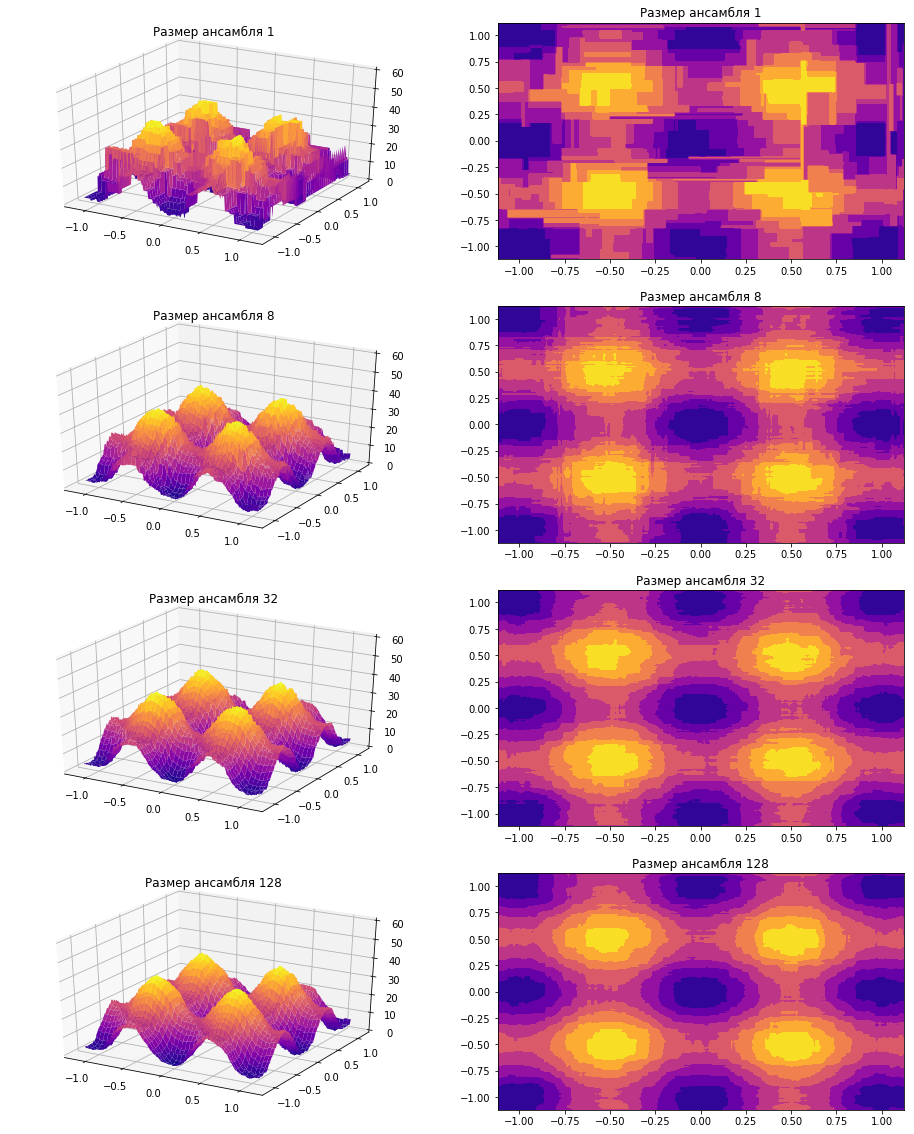

In [413]:
ensemble_sizes = [1, 8, 32, 128]
scores = []

fig = plt.figure(figsize=(16, 5 * len(ensemble_sizes)))
for n, size in enumerate(ensemble_sizes):
    ensemble = ExtraTreesRegressor(n_estimators=size)
    ensemble.fit(X_train, y_train)

    y_pred = ensemble.predict(X_test)
    y_pred = y_pred.reshape(xx.shape)
    
    ax = plt.subplot(4, 2, 2*n + 1, projection='3d')
    ax.set_title(f'Размер ансамбля {size}')
    ax.plot_surface(xx, yy, y_pred, cmap='plasma')
    ax.set_zlim(0, 60)

    ax = plt.subplot(4, 2, 2*n + 2)
    ax.contourf(xx, yy, y_pred, cmap='plasma')
    ax.set_title(f'Размер ансамбля {size}')

    scores.append(mean_squared_error(y_test, y_pred))
   
plt.show()

Теперь построим сам график улучшения качества.

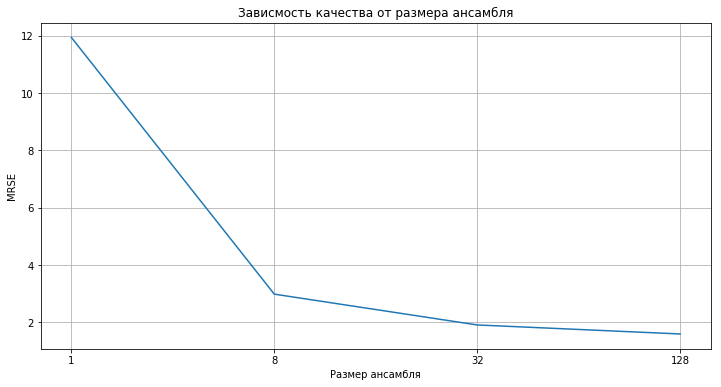

In [429]:
plt.figure(figsize=(12, 6))
plt.title('Зависмость качества от размера ансамбля')

plt.plot(scores)

plt.xticks(np.arange(len(ensemble_sizes)), ensemble_sizes)
plt.xlabel('Размер ансамбля')
plt.ylabel('MRSE')

plt.grid()
plt.show()

Попробуем улучшить качество, используя несколько деревьев.

In [216]:
ensemble = ExtraTreesClassifier(max_features='sqrt')

parameter_grid = {
    'max_depth' : [3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [200, 210, 240, 250],
}

grid_search = GridSearchCV(
    ensemble,
    param_grid = parameter_grid,
    cv = StratifiedKFold(n_splits=5).split(train, targets)
)

grid_search.fit(train_new, targets)

score = grid_search.best_score_
params = grid_search.best_params_ 

print(f'Best score: {score}')
print(f'Best parameters: {params}')

Best score: 0.8249158249158249
Best parameters: {'max_depth': 8, 'n_estimators': 240}


Как можно видеть, используя такую простую идея, как ансамбль можно значительно улучшить качество обучения.